# 1. Использование нейронных сетей прямого распространения для решения задач классификации

### Цель работы

Изучение основ работы с нейронными сетями прямого распространения (FNN) для классификации данных, обучение модели на подготовленном датасете, анализ и оценка полученных результатов

### Задачи

1.	Ознакомиться с принципом работы сети прямого распространения (FNN) и её применением в задачах классификации.
2.	Подготовить датасет для обучения модели.
3.	Реализовать и обучить нейронную сеть прямого распространения (FNN) с использованием выбранного инструмента (PyTorch, TensorFlow или Keras).
4.	Провести обучение сети на подготовленных данных.
5.	Оценить точность работы модели и проанализировать полученные результаты.

### Вариант задания

Используем датасет FER-2013, содержащий изображения лиц с разметкой по эмоциям (грусть, радость, удивление и т. д.). Нужно обучить нейронную сеть для классификации эмоций на изображениях.

### Ход выполнения работы

Первым шагом при выполнении работы необходимо скачать датасет для "FER-2013", который можно найти на сайте [Kaggle](https://www.kaggle.com/datasets/msambare/fer2013).

Данные состоят из изображений лиц в оттенках серого размером 48x48 пикселей. Фотографии обрезаны таким образом, чтобы лицо было более или менее центрировано и занимало примерно одинаковое пространство на каждом изображении.

Задача состоит в том, чтобы классифицировать каждое лицо на основе эмоции, проявляющейся в выражении лица, в одну из семи категорий: 
1. angry - злость (0)
2. disgust - отвращение (1)
3. fear - страх (2)
4. happy - счастье (3)
5. sad - грусть (4)
6. surprise - удивление (5)
7. neutral - нейтральное (6)

Обучающий набор состоит из 28709 примеров, а тестовый набор - из 3589 примеров.

Для начала работы создается и активируется виртуальное окружение, чтобы в дальнейшем не возникало конфликтов в глобальном окружении

In [1]:
# !python3 -m venv venv
!source venv/bin/activate

Далее скачиваются необходимые пакеты, а именно `tensorflow`

In [2]:
# В настоящее время нет официальной поддержки графического процессора для MacOS
# !python3 -m pip install tensorflow
# Проверка установки:
# !python3 -c "import tensorflow as tf; print(tf.reduce_sum(tf.random.normal([1000, 1000])))"

Далее производится импорт необходимых для работы библиотек.

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Данные загружаются с помощью метода `image_dataset_from_directory`

In [4]:
img_size = (48, 48)  # размер изображений
batch_size = 64  # размер пакета данных
train_dir = "datasets/FER-2013/train" # путь к тренеровочным данным
test_dir = "datasets/FER-2013/test"   # путь к тестовым данным

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    color_mode="grayscale"
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    color_mode="grayscale"
)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


Для проверки корректности определения имен классов выводится список с определенными названиями с помощью специального атрибута.

In [5]:
class_labels = train_ds.class_names
class_labels

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Далее необходимо нормализовать изображения, путем перевода значений пикселей из диапазона от 0 до 255 в диапазон от 0 до 1. Это ускоряет и стабилизирует обучение нейросети, потому что маленькие значения лучше обрабатываются. Это помогает ускорить сходимость градиентного спуска. Также уменьшается влияние разницы в яркости и контрасте изображений. 

Также для целевой переменной (меток классов) применим One-hot encoding, то есть кодирование категориальных данных, где каждая категория представляется вектором с одним единичным элементом и остальными нулями. Например класс №2 будет представлен в виде вектора [0, 0, 1, 0, 0, 0, 0]. Это представление используется для работы с нейронными сетями, так как позволяет хорошо разделять классы.

In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), 
                                        tf.keras.utils.to_categorical(y, num_classes=7)))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), 
                                    tf.keras.utils.to_categorical(y, num_classes=7)))

Производится визуализация примеров изображений из датасета с подписями меток классов.

2025-02-22 23:57:19.986744: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


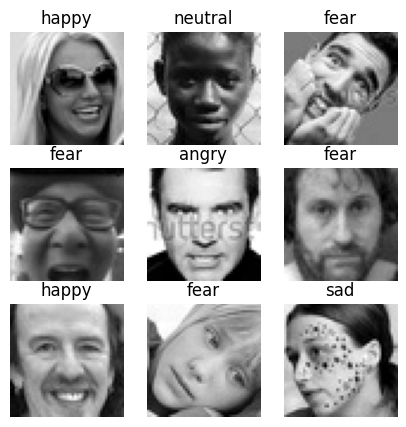

In [7]:
plt.figure(figsize=(5, 5))

for img, labels in train_ds.take(1):  # берется один батч
    for i in range(9):
        plt.subplot(3, 3, i + 1) 
        plt.imshow(img[i].numpy().squeeze(), cmap="gray")
        label_index = np.argmax(labels[i].numpy())
        plt.title(class_labels[label_index])
        plt.axis("off")

plt.show()

Следующим шагом с помощью `TensorFlow/Keras` создается сама модель нейронной сети прямого распространения или по-другому - `FNN` (Fully Connected Neural Network). `FNN` — это полносвязная нейросеть, состоящая из слоев `Dense`.

Создается последовательная модель `Sequential`, где слои идут друг за другом. Сначала добавляется входной слой `Input`, который принимает данные. Затем необходимо преобразовать двумерные изображения в одномерный вектор, так как на вход нейронной сети подается именно одномерный вектор. Нейросети проще работать с векторами, а не с изображениями, поэтому матрица 48x48 преобразуется в одномерный вектор из 2304 элементов (48*48) с помощью второго слоя.

Третий слой будет состоять из 128 нейронов, каждый из которых полностью связан со входными данными. В качестве фукнции активации выбирается `ReLU` (Rectified Linear Unit), которая работает следующим образом:
- если x > 0, то возвращается 1;
- если x ≤ 0, то возвращается 0.

Четвертый слой состоит из 64 нейронов. В качестве функции активации используется также `ReLU`. Второй слой необходим, чтобы нейронная сеть могла выделять сложные паттерны в данных. Чем глубже сеть, тем лучше она обучается.

В последнем выходном слое создается 7 нейронов, так как в исследуемых данных 7 классов. В качестве функции активации в последнем слое используется Softmax, который переводит выходные значения в вероятности, где сумма всех выходных значений равна 1.


In [8]:
model = keras.Sequential([
    layers.Input(shape=(48, 48, 1)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(7, activation='softmax')
])

При помощи команды `model.summary()` смотрятся параметры модели.

In [9]:
model.summary() 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303,751 (1.16 MB)

 Trainable params: 303,751 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Вывод команды `model.summary()` показывает структуру модели и информацию о количестве параметров на каждом слое. Первый слой преобразует входное изображение размером 48x48 в одномерный вектор длиной 2304 элемента, и не имеет обучаемых параметров. Далее идет два полносвязных слоя, которые обрабатывают этот вектор: первый слой имеет 128 нейронов и 295,040 параметров, второй слой имеет 64 нейрона и 8,256 параметров. Выходной слой состоит из 7 нейронов (по количеству классов) и имеет 455 параметров. В сумме модель имеет 911,255 параметров, из которых 303,751 обучаемых. Это количество параметров указывает на сложность модели.

Перед обучением настроиваются параметры модели. В качестве оптимизатора задается `adam`, который обновляет веса во время обучения.

Также необходимо указать функцию потерь (loss function) - функцию, которая будет считать ошибку предсказания, то есть насколько предсказанные моделью метки классов отличаются от реальных.

В модели используется функция потерь `categorical_crossentropy`, так как она хорошо подходит для задач многоклассовой классификации. 
Она сравнивает предсказанную моделью вероятность для каждого класса с реальной меткой. Если модель ошибается, функция потерь "штрафует" ее. Модель должна минимизировать фукнцию потерь, чтобы предсказания были более точными.

В качестве метрики выбирается accuracy (точность), которая показывает долю правильных предсказаний. С помощью метрики оценивается качество модели после каждой эпохи.

In [10]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

На данном этапе происходит процесс обучения модели. История обучения сохраняется в `history`. 

Для начала обучение производится с заданным кол-вом эпох - 30. Эпохи - это количество полных проходов через весь набор данных, которые модель делает во время обучения для корректировки весов. Большое кол-во эпох приводит к переобучению, а маленькое, соответственно, к недообучению.

Для оценки качества обученности модели делается визуализация точности и потерь по эпохам обучения.

По графикам было видно, что после 13 эпохи ошибки на тестовой выборке перестали также уменьшаться как на тренировочной и такая же ситуация с точностью. Поэтому принимается решение обучить модель с кол-вом эпох равным 13.

После обучения на 13 эпохах стало ясно, что переобучение наступает после 10 эпохи. Поэтому было принято решение переобучить модель на 10 эпохах.

In [11]:
history = model.fit(train_ds, validation_data=test_ds, epochs=10)

Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2579 - loss: 1.8297 - val_accuracy: 0.3415 - val_loss: 1.6998
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3273 - loss: 1.7018 - val_accuracy: 0.3079 - val_loss: 1.7381
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3432 - loss: 1.6808 - val_accuracy: 0.3692 - val_loss: 1.6417
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3527 - loss: 1.6485 - val_accuracy: 0.3546 - val_loss: 1.6488
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3589 - loss: 1.6304 - val_accuracy: 0.3586 - val_loss: 1.6311
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3683 - loss: 1.6105 - val_accuracy: 0.3749 - val_loss: 1.5929
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3701 - loss: 1.6036 - val_accuracy: 0.3780 - val_loss: 1.5886
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3765 - loss: 1.5833 - val_accuracy: 0.

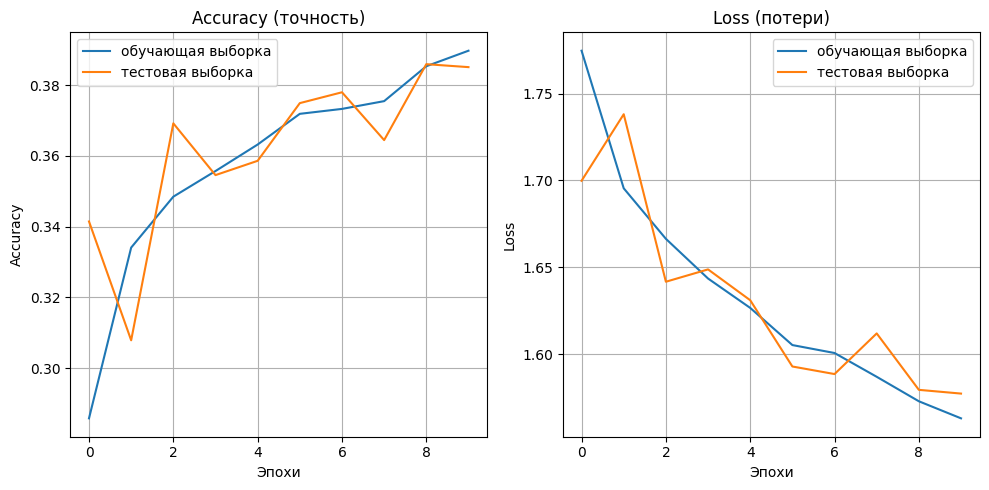

In [12]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Accuracy (точность)')
plt.plot(history.history['accuracy'], label='обучающая выборка')
plt.plot(history.history['val_accuracy'], label='тестовая выборка')
plt.xlabel('Эпохи')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Loss (потери)')
plt.plot(history.history['loss'], label='обучающая выборка')
plt.plot(history.history['val_loss'], label='тестовая выборка')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

На графиках видно, что проблема переобучения была устранена. Но тем не менее видно, что точность модели довольно низкая (около 0.39). проблема в том, что нейронные сети прямого распространения (FNN) не учитывают пространственные зависимости в изображениях. Для данной задачи лучше подошла бы сверточная нейронная сеть, которая использует паттерны на изображениях для верной классификации.

### Выводы

В ходе работы была обучена модель нейронной сети прямого распространения (FNN) для классификации изображений эмоций из датасета FER-2013. На этапе обучения модель прошла 30 эпох, однако анализ графиков изменения точности и потерь показал, что после 13-й эпохи начали проявляться признаки переобучения. Было принято решение повторно обучить модель с 13 эпохами, но дальнейший анализ показал, что оптимальным количеством является 10 эпох, так как переобучение начинается именно после этого момента.

В ходе работы была обучена модель нейронной сети прямого распространения (FNN) для классификации изображений эмоций из датасета `FER-2013`. На этапе обучения модель прошла 30 эпох, однако анализ графиков изменения точности и потерь показал, что после 10 эпохи начали проявляться признаки переобучения. Было принято решение повторно обучить модель с 10 эпохами, что оказалось оптимальным количеством эпох, так как переобучение начинается именно после этого момента.  

После корректировки количества эпох удалось снизить переобучение, однако итоговая точность модели осталась довольно низкой — около 0.39. Основная причина заключается в том, что FNN плохо работает с изображениями, поскольку не учитывает пространственные зависимости и особенности пиксельных паттернов. Более подходящим решением для данной задачи является использование сверточной нейронной сети, которая может эффективно анализировать изображения.  